In [1]:
import os
import time
import random
import math

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from transformers import DataCollatorForLanguageModeling, BertForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from data import CausalBertSynDataset
from causal_bert import CausalBOW, CausalBert, load_data, true_casual_effect, est_casual_effect

In [2]:
def true_casual_effect(data_loader, effect='ate', estimation='q'):
    assert estimation == 'q', f'unallowed estimation: {estimation}'
    
    dataset = data_loader.dataset
    
    Q1 = dataset.treatment * dataset.response + (1 - dataset.treatment) * dataset.pseudo_response
    Q1 = Q1.cpu().data.numpy().squeeze()

    Q0 = dataset.treatment * dataset.pseudo_response + (1 - dataset.treatment) * dataset.response
    Q0 = Q0.cpu().data.numpy().squeeze()

    treatment = dataset.treatment.cpu().data.numpy().squeeze()
    prop_scores = dataset.prop_scores.cpu().data.numpy().squeeze()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (treatment * (Q1 - Q0))
            return phi.sum() / treatment.sum()
        elif effect == 'ate':
            return (Q1 - Q0).mean()
        
    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / treatment.mean()
        elif effect == 'ate': 
            return phi

In [3]:
low = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/[BEST]_[0,25-1,0]_C-BERT_64_22.pth'
med = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/[BEST]_[0,5-5,0]_C-BERT_64_22.pth'
high = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/[BEST]_[0,75-25,0]_C-BERT_64_22.pth'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = torch.load(low).to(device)

In [5]:
alpha = 0.25
beta = 1.
offset_t = 0
offset_p = 0.2

train, test = load_data(alpha, beta, offset_t, offset_p, 16, device=device)

Load training set in 65.59 sec
Training set: [treated: 0.2375], [prop scores counts: 0.0626]
Load validation set in 68.68 sec
Testing set: [treated: 0.2381], [prop scores counts: 0.0635]
****************************************************************************************************


In [6]:
prop_scores = []

treatments = []
responses = []
real_prop_scores = []

tokens = []
model.eval()
for idx, (token, treatment, response, real_prop_score) in enumerate(test):
    prop_score, _, _ = model(token)
    if model.prop_is_logit:
        sigmoid = nn.Sigmoid()
        prop_score = sigmoid(prop_score)
    prop_scores.append(prop_score.cpu().data.numpy().squeeze())
    treatments.append(treatment.cpu().data.numpy().squeeze())
    responses.append(response.cpu().data.numpy().squeeze())
    real_prop_scores.append(real_prop_score.cpu().data.numpy().squeeze())
    tokens.append(token.cpu().data.numpy().squeeze())
    
prop_scores = np.concatenate(prop_scores, axis=0)
treatments = np.concatenate(treatments, axis=0)
responses = np.concatenate(responses, axis=0)
real_prop_scores = np.concatenate(real_prop_scores, axis=0)
tokens = np.concatenate(tokens, axis=0)

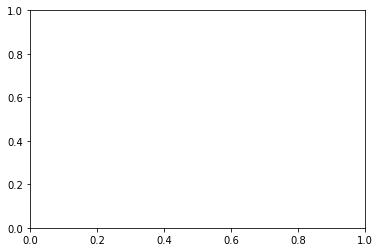

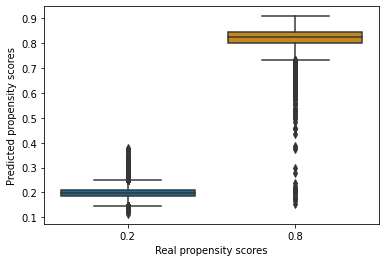

In [12]:
dat = np.array([real_prop_scores, prop_scores]).T
dat = pd.DataFrame(dat, columns=['real_prop_scores', 'pred_prop_scores'])

plt.cla()
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.boxplot(y='pred_prop_scores', x='real_prop_scores', data=dat, palette="colorblind", )
ax.set_xlabel('Real propensity scores')
ax.set_ylabel('Predicted propensity scores')
plt.savefig('./w42_weight_low.png')

In [9]:
def est_effect(responses, treatments, prop_scores, est, outlier=None):
    
    if outlier:
        responses = responses[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
        treatments = treatments[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
        prop_scores = prop_scores[(prop_scores > outlier) & (prop_scores < 1 - outlier)]

    w_ate = treatments / prop_scores + (1 - treatments) / (1 - prop_scores)
    w_att = treatments + (1 - treatments) * prop_scores / (1 - prop_scores)

    if est == 'ate':
        w = w_ate
    else:
        w = w_att
    e1 = (responses * treatments * w).sum() / (treatments * w).sum()
    e2 = (responses * (1 - treatments) * w).sum() / ((1 - treatments) * w).sum()
    
    return e1 - e2

In [13]:
print(f'real ATE: {true_casual_effect(test, "ate"):.4f}')
print(f'Weighted estimated ATE: {est_effect(responses, treatments, prop_scores, "ate"):.4f}')
print(f'Unadjusted estimated ATE: {(responses[treatments == 1].mean() - responses[treatments == 0].mean()):.4f}')

real ATE: 0.0641
Weighted estimated ATE: 0.0586
Unadjusted estimated ATE: 0.0869
